# Example: Spatially varying advection

In [5]:
import spdepy as sp
import numpy as np
import matplotlib.pyplot as plt

In [27]:
bc = 3

M = 15 
N = 15
T = 12
x = np.linspace(0, 15, M)
y = np.linspace(0, 15, N)
ts = np.arange(0, T).astype("float64")

# np.savez("data/grid.npz", x=x, y=y, t=ts)

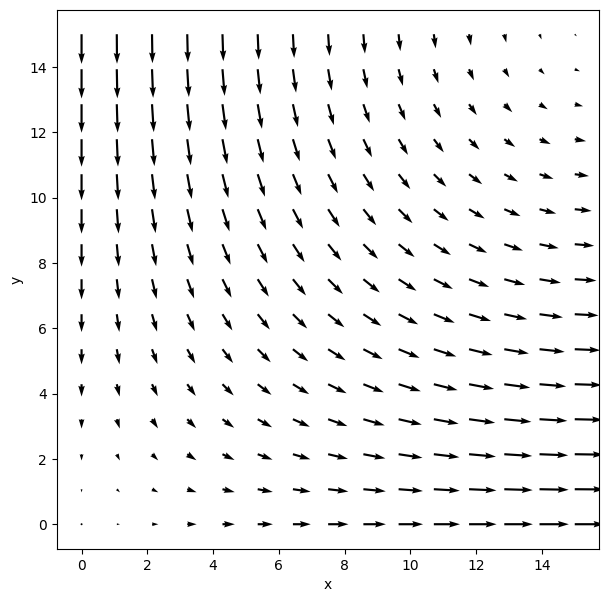

In [31]:

X, Y, _= np.meshgrid(x, y, ts)
sx, sy = np.meshgrid(x, y)
sx = sx.flatten()
sy = sy.flatten()

def getVx(x,y):
    return np.sin(x/10)*np.cos(y/10)

def getVy(x,y):
    return -np.cos(x/10)*np.sin(y/10)

def getPerpVx(x,y):
    return -np.cos(x/10)*np.sin(y/10)

def getPerpVy(x,y):
    return -np.sin(x/10)*np.cos(y/10)

vx = getVx(X,Y)
vy = getVy(X,Y)

fig, ax = plt.subplots(figsize=(7, 7))
rect = plt.Rectangle((4,4),6,6,linewidth=1,edgecolor='r',facecolor='none')
ax.quiver(X[:,:,0], Y[:,:,0], vx[:,:,0], vy[:,:,0])
# ax.add_patch(rect)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.savefig("../../../spat_temp_paper/figures/simstud_vec1.png", dpi=200)


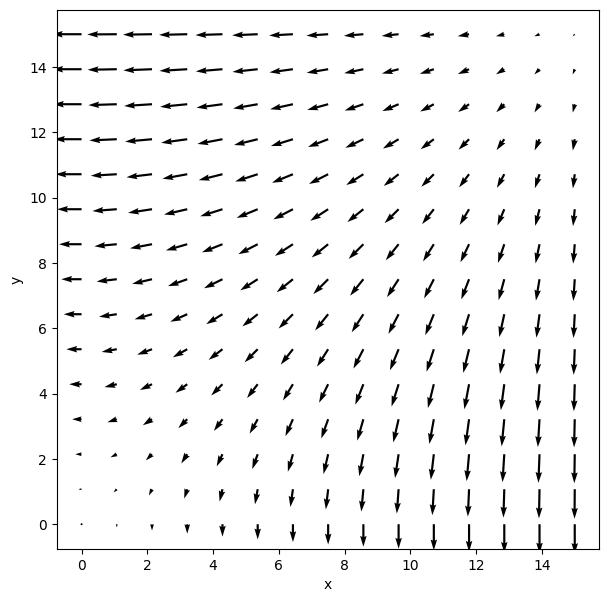

In [32]:
vx = getPerpVx(X,Y)
vy = getPerpVy(X,Y)

fig, ax = plt.subplots(figsize=(7, 7))
rect = plt.Rectangle((4,4),6,6,linewidth=1,edgecolor='r',facecolor='none')
ax.quiver(X[:,:,0], Y[:,:,0], vx[:,:,0], vy[:,:,0])
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.savefig("../../../spat_temp_paper/figures/simstud_vec2.png", dpi=200)

In [8]:
mod = sp.model(grid = sp.grid(x=x, y=y, t = ts), spde = 'var-advection-var-diffusion', 
               ha = False, bc = bc, anisotropic = True)

In [9]:
from scipy.optimize import minimize
svxa = getVx(sx,sy)
svya = getVy(sx,sy)
svxd = getPerpVx(sx,sy)
svyd = getPerpVy(sx,sy)

    
def findPerpVx(par):
    res = ((mod.grid.evalB(par = par) - svxd)**2).mean()
    return res

def findPerpVy(par):
    res = ((mod.grid.evalB(par = par) - svyd)**2).mean()
    return res
    
def findVx(par):
    res = ((mod.grid.evalB(par = par) - svxa)**2).mean()
    return res

def findVy(par):
    res = ((mod.grid.evalB(par = par) - svya)**2).mean()
    return res

resd1 = minimize(findPerpVx, x0 = np.random.normal(size = 9), method = "Nelder-Mead")
resd2 = minimize(findPerpVy, x0 = np.random.normal(size = 9), method = "Nelder-Mead")
resd1 = minimize(findPerpVx, x0 = resd1.x, method = "Nelder-Mead")
resd2 = minimize(findPerpVy, x0 = resd2.x, method = "Nelder-Mead")
resa1 = minimize(findVx, x0 = np.random.normal(size = 9), method = "Nelder-Mead")
resa2 = minimize(findVy, x0 = np.random.normal(size = 9), method = "Nelder-Mead")
resa1 = minimize(findVx, x0 = resa1.x, method = "Nelder-Mead")
resa2 = minimize(findVy, x0 = resa2.x, method = "Nelder-Mead")

Text(0, 0.5, 'y')

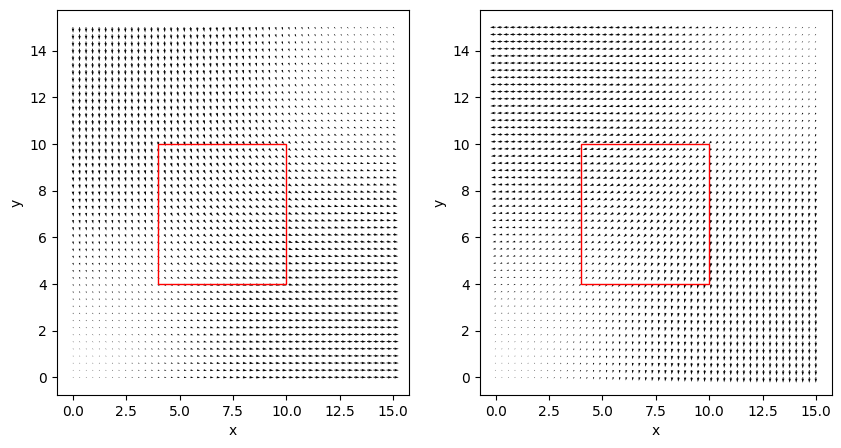

In [10]:
fig, ax = plt.subplots(ncols = 2,figsize=(10, 5))
rect1 = plt.Rectangle((4,4),6,6,linewidth=1,edgecolor='r',facecolor='none')
rect2 = plt.Rectangle((4,4),6,6,linewidth=1,edgecolor='r',facecolor='none')
ax[0].quiver(X[:,:,0], Y[:,:,0], mod.grid.evalB(par = resa1.x).reshape(N,M), mod.grid.evalB(par = resa2.x).reshape(N,M))
ax[1].quiver(X[:,:,0], Y[:,:,0], mod.grid.evalB(par = resd1.x).reshape(N,M), mod.grid.evalB(par = resd2.x).reshape(N,M))
ax[0].add_patch(rect1)
ax[1].add_patch(rect2)
ax[0].set_xlabel('x')
ax[1].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_ylabel('y')

In [11]:
parS = np.array([-3,-1,0.5,-0.5,np.log(10)])
# np.save("data/mod0pars.npy", parS)
parT = np.hstack([[-3]*9,[-3]*9,resd1.x*0.1,resd2.x*0.1,resa1.x*10,resa2.x*10,-4,np.log(10)])
mod0 = sp.model(grid = sp.grid(x=x, y=y, extend = 5),
         spde = 'whittle-matern', parameters = parS, ha = False, bc = bc, anisotropic = True)

mod = sp.model(grid = sp.grid(x=x, y=y, t = ts, extend = 5),
        spde = 'var-advection-var-diffusion', ha = False, bc = bc, anisotropic = True, mod0 = mod0, parameters = parT)

mod.setModel()
# data = mod.sample()[:,0]
# res = np.zeros((mod.grid.T,mod.grid.T))
# for t in range(mod.grid.T):
#     mod.setModel()
#     tidx = np.array([mod.grid.getIdx([x,y,t],extend = False) for x in range(mod.grid.M) for y in range(mod.grid.N)])
#     mod.update(y = data[tidx],idx = tidx, tau = 1000)
#     tmp2 = (mod.grid.getS()@mod.mu).reshape(mod.grid.T, mod.grid.N,mod.grid.M)
#     res[t,:] = np.sqrt((mod.grid.getS()@mod.mu - data)**2).reshape(mod.grid.T, mod.grid.M*mod.grid.N).mean(axis = 1)

# im = list()
# fig, ax = plt.subplots(figsize = (20,10),ncols=4,nrows=3)
# for t in range(mod.grid.T):
#     ax[t//4,t%4].plot(res[t,:])
   

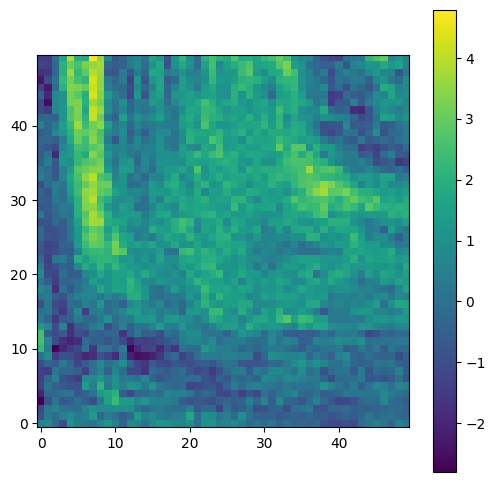

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(mod.sample(seed = None).reshape(T,N,M)[3,:,:],origin='lower')
clb = fig.colorbar(im, ax=ax)

- Parameterized varying advection (Simulated from)
- Simple advection diffusion model
- Spatial model
- Seperable space time model (possbily complex)

In [13]:
tmp = mod.sample(n = 20,seed = 69)
tmp2 = np.ma.masked_array(tmp, mask = np.zeros (tmp.shape))
idx = []
idxS = []
for t in range(T):
    for i in range(M):
        for j in range(N):
            if 19 < i < 38:
                if 12 < j < 31:
                    tmp2.mask[t*M*N + j*M + i] = True
                    idx.append(t*M*N + j*M + i)
                    if t == 0:
                        idxS.append(j*M + i)
                    
idxD = np.delete(np.arange(0,M*N*T),idx)
idxDS = np.delete(np.arange(0,M*N),idxS)
tmp3 = np.zeros((M*N,T*tmp.shape[1]))
for i in range(tmp.shape[1]):
    tmp3[:,i*T:(i+1)*T] = tmp[:,i].reshape(T,N*M).T                    
# np.save("data/data.npy", tmp[idxD,:])
# np.save("data/dataS.npy", tmp3[idxDS,:])
# np.save("data/idxD.npy", idxD)
# np.save("data/idxDS.npy", idxDS)
# np.save("data/idx.npy", idx)
# np.save("data/idxS.npy", idxS)
# np.save("data/test.npy", tmp)
# np.save("data/testS.npy", tmp3)

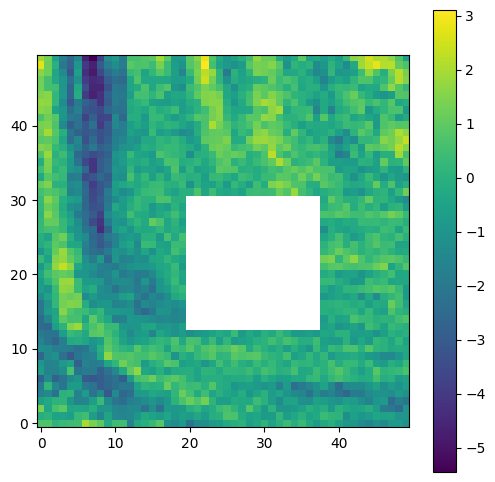

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(tmp2[:,0].reshape(T,N,M)[2,:,:],origin='lower')
clb = fig.colorbar(im, ax=ax)

## Make video and paper picture

In [196]:
import cv2

In [246]:
ver = 5
shind = np.array([0,10,20,30,40,49])
cmax = tmp[:,ver].max()
cmin = tmp[:,ver].min()
for i in range(T):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(tmp[:,ver].reshape(T,N,M)[i,:,:],origin='lower',alpha = 0.5, cmap = "viridis",vmin = cmin, vmax = cmax)
    im = ax.imshow(tmp2[:,ver].reshape(T,N,M)[i,:,:],origin='lower',cmap = "viridis",vmin = cmin, vmax = cmax)
    clb = fig.colorbar(im, ax=ax)
    ax.set_xlabel('x', fontsize = 15)
    ax.set_ylabel('y', fontsize = 15)
    ax.set_xticks(np.arange(M)[shind],np.array(["%.1f"%xs for xs in x])[shind])
    ax.set_yticks(np.arange(N)[shind],np.array(["%.1f"%ys for ys in y])[shind])
    fig.suptitle('t = ' + str(i), fontsize = 15, y = 0.92, x = 0.48)
    fig.savefig("video/t%02d.png"%i,dpi = 200, bbox_inches = "tight")
    fig.set_size_inches(8, 6, forward=True)
    plt.close()
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video = cv2.VideoWriter('./video/videoAD.mp4', fourcc, 3, (1266, 1112))

for i in range(T):
    img = cv2.imread('video/t%02d.png'%i)
    video.write(img)

cv2.destroyAllWindows()
video.release()

## Evaluate the results

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import spdepy as sp

In [16]:
grid = np.load('data/grid.npz')
idx = np.load('data/idx.npy')
data = np.load('data/test.npy')

mod0 = sp.model(grid = sp.grid(x=grid['x'], y=grid['y'], extend = 5),
        spde = 'whittle-matern', parameters = np.load('data/mod0pars.npy'),
        ha = False, bc = bc, anisotropic = True)

ADmod = sp.model(grid = sp.grid(x=grid['x'], y=grid['y'], t = grid['t'],extend = 5), parameters = np.load('./fits/advection_diffusion_ani_bc3.npy'),
        spde = 'advection-diffusion', ha = False, bc = bc, anisotropic = True, mod0 = mod0)
SSTmod = sp.model(grid = sp.grid(x=grid['x'], y=grid['y'], t = grid['t'],extend = 5), parameters = np.load('./fits/seperable_spatial_temporal_ani_bc3.npy'),
        spde = 'seperable-spatial-temporal', ha = False, bc = bc, anisotropic = True, mod0 = mod0)
# WMmod = sp.model(grid = sp.grid(x=grid['x'], y=grid['y'],extend = 5), parameters = np.load('./fits/whittle_matern_ani_bc3.npy'),
#         spde = 'whittle-matern', ha = False, bc = bc, anisotropic = True, Q0 = mod0.mod.Q)
# vWMmod = sp.model(grid = sp.grid(x=grid['x'], y=grid['y'],extend = 5), parameters = np.load('./fits/var_whittle_matern_ani_bc3.npy'),
#         spde = 'var-whittle-matern', ha = False, bc = bc, anisotropic = True, Q0 = mod0.mod.Q)
vAvDmod = sp.model(grid = sp.grid(x=grid['x'], y=grid['y'], t = grid['t'],extend = 5), parameters = np.load('./fits/var_advection_var_diffusion_ani_bc3.npy'),
        spde = 'var-advection-var-diffusion', ha = False, bc = bc, anisotropic = True, mod0=mod0)

In [17]:
from tqdm import tqdm
from scipy.stats import norm
def getTempRes(mod):
    mod.setModel()
    res = np.zeros((data.shape[1],mod.grid.T))
    res2 = np.zeros((data.shape[1],mod.grid.T))
    n = np.zeros((data.shape[1],mod.grid.T))
    nidx = np.arange(mod.grid.M*mod.grid.N*mod.grid.T)
    for i in tqdm(range(data.shape[1])):
        for t in range(mod.grid.T):
            mod.setModel()
            uidx = np.zeros(mod.grid.M*mod.grid.N*mod.grid.T).astype(bool) 
            tidx = np.array([mod.grid.getIdx([x,y,t],extend = False) for x in range(mod.grid.M) for y in range(mod.grid.N)])
            uidx[tidx] = True
            uidx[idx] = False
            mod.update(y = data[uidx,i] ,idx = nidx[uidx])
            tmp = np.sqrt((mod.grid.getS()@mod.mu - data[:,i])**2).reshape(mod.grid.T, -1)
            mvar = mod.qinv(simple = True)
            z = (data[:,i] - mod.grid.getS()@mod.mu)/np.sqrt(mvar)
            tmp2 = (np.sqrt(mvar) * (z*(2*norm.cdf(z)-1) + 2*norm.pdf(z) - np.sqrt(1/np.pi))).reshape(mod.grid.T, -1)
            res[i,:(mod.grid.T - t)] += [tmp[t+j,~uidx.reshape(mod.grid.T,-1)[t+j,:]].mean() for j in range(mod.grid.T - t)]
            res2[i,:(mod.grid.T - t)] += [tmp2[t+j,~uidx.reshape(mod.grid.T,-1)[t+j,:]].mean() for j in range(mod.grid.T - t)]
            n[i,:(mod.grid.T-t)] += 1
    return (res/n,res2/n)

In [18]:
resTrue,resTrue2 = getTempRes(mod)
resAD, resAD2 = getTempRes(ADmod)
resSST, resSST2 = getTempRes(SSTmod)
# resWM = getTempResS(WMmod)
# resvWM = getTempResS(vWMmod)
resvAvD, resvAvD2 = getTempRes(vAvDmod)

 35%|███▌      | 7/20 [12:10<22:36, 104.37s/it]


KeyboardInterrupt: 

In [14]:
np.savez("data/temporal_res2.npz", resTrue = resTrue, resTrue2 = resTrue2, resAD = resAD, resAD2 = resAD2, resSST = resSST, resSST2 = resSST2, resvAvD = resvAvD, resvAvD2 = resvAvD2)

In [19]:
tmp = np.load("data/temporal_res2.npz")
resTrue, resTrue2, resAD, resAD2, resSST, resSST2, resvAvD, resvAvD2 = tmp['resTrue'], tmp['resTrue2'], tmp['resAD'], tmp['resAD2'], tmp['resSST'], tmp['resSST2'], tmp['resvAvD'], tmp['resvAvD2']

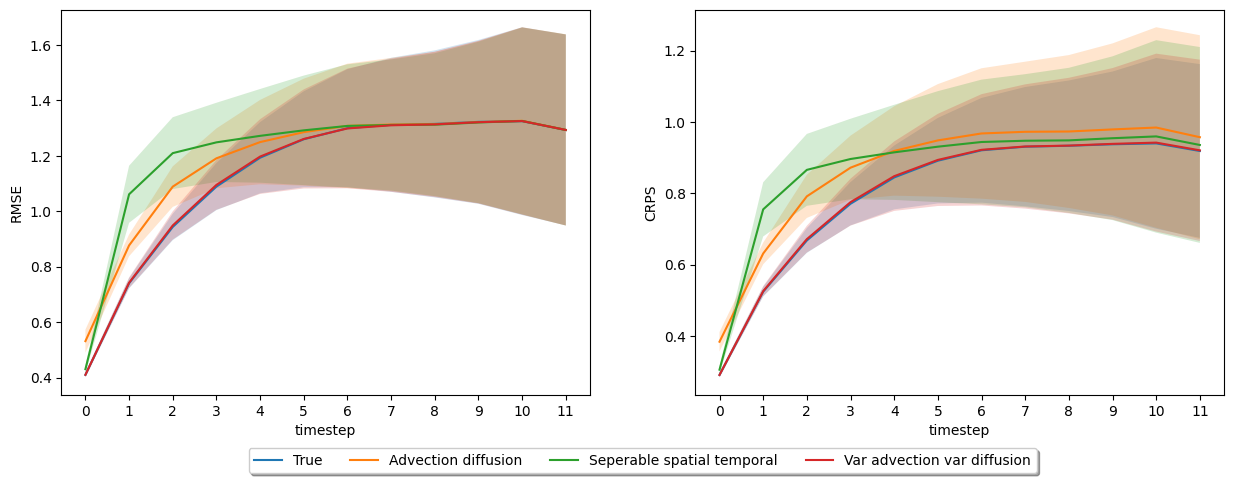

In [21]:
fig, ax = plt.subplots(figsize=(15, 5),ncols = 2)
ns = 12 
stm = np.arange(ns).astype("int32")
ax[0].plot(stm,resTrue.mean(axis=0)[:ns], label = 'True')
ax[1].plot(stm,resTrue2.mean(axis=0)[:ns], label = 'True')
ax[0].fill_between(stm, ( resTrue.mean(axis=0) - resTrue.std(axis=0) )[:ns], (resTrue.mean(axis=0) + resTrue.std(axis=0))[:ns], alpha = 0.2)
ax[1].fill_between(stm, ( resTrue2.mean(axis=0) - resTrue2.std(axis=0) )[:ns], (resTrue2.mean(axis=0) + resTrue2.std(axis=0))[:ns], alpha = 0.2)
ax[0].plot(stm,resAD.mean(axis = 0)[:ns], label = 'Advection diffusion')
ax[1].plot(stm,resAD2.mean(axis = 0)[:ns], label = 'Advection diffusion')
ax[0].fill_between(stm, (resAD.mean(axis=0) - resAD.std(axis=0))[:ns], (resAD.mean(axis=0) + resAD.std(axis=0))[:ns], alpha = 0.2)
ax[1].fill_between(stm, (resAD2.mean(axis=0) - resAD2.std(axis=0))[:ns], (resAD2.mean(axis=0) + resAD2.std(axis=0))[:ns], alpha = 0.2)
ax[0].plot(stm,resSST.mean(axis = 0)[:ns], label = 'Seperable spatial temporal')
ax[1].plot(stm,resSST2.mean(axis = 0)[:ns], label = 'Seperable spatial temporal')
ax[0].fill_between(stm, (resSST.mean(axis=0) - resSST.std(axis=0))[:ns], (resSST.mean(axis=0) + resSST.std(axis=0))[:ns], alpha = 0.2)
ax[1].fill_between(stm, (resSST2.mean(axis=0) - resSST2.std(axis=0))[:ns], (resSST2.mean(axis=0) + resSST2.std(axis=0))[:ns], alpha = 0.2)
ax[0].plot(stm,resvAvD.mean(axis = 0)[:ns], label = 'Var advection var diffusion')
ax[1].plot(stm,resvAvD2.mean(axis = 0)[:ns], label = 'Var advection var diffusion')
ax[0].fill_between(stm, (resvAvD.mean(axis=0) - resvAvD.std(axis=0))[:ns], (resvAvD.mean(axis=0) + resvAvD.std(axis=0))[:ns], alpha = 0.2)
ax[1].fill_between(stm, (resvAvD2.mean(axis=0) - resvAvD2.std(axis=0))[:ns], (resvAvD2.mean(axis=0) + resvAvD2.std(axis=0))[:ns], alpha = 0.2)
ax[0].set_xticks(stm)
ax[1].set_xticks(stm)

ax[1].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.12),
          fancybox=True, shadow=True, ncol=4)
ax[0].set_xlabel('timestep')
ax[1].set_xlabel('timestep')
ax[0].set_ylabel('RMSE')
ax[1].set_ylabel('CRPS')

fig.savefig("../../../spat_temp_paper/figures/simstud_advection_diffusion_full.png",bbox_inches='tight',dpi = 200)

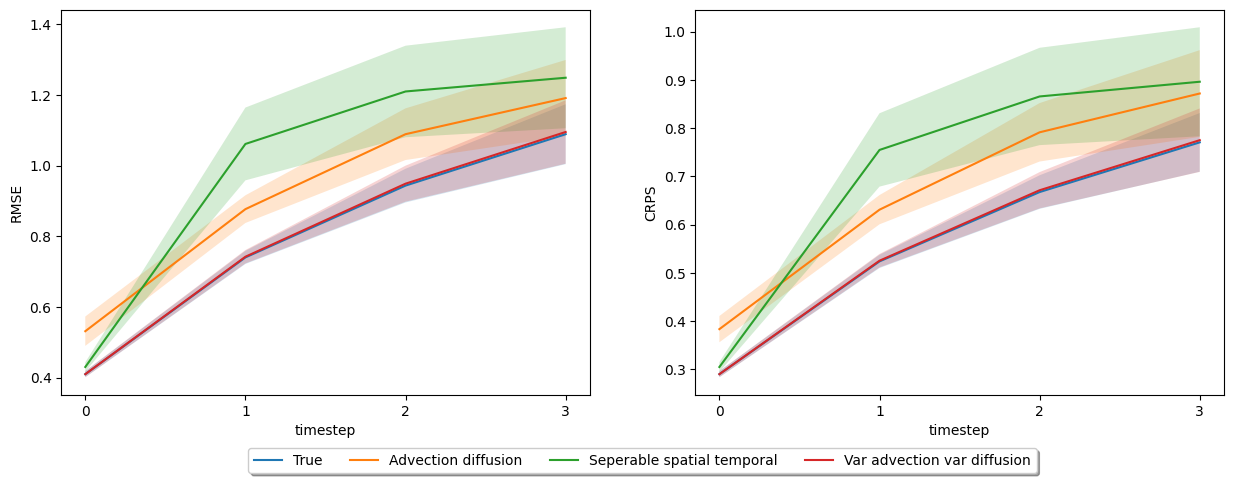

In [20]:
fig, ax = plt.subplots(figsize=(15, 5),ncols = 2)
ns = 4
stm = np.arange(ns).astype("int32")
ax[0].plot(stm,resTrue.mean(axis=0)[:ns], label = 'True')
ax[1].plot(stm,resTrue2.mean(axis=0)[:ns], label = 'True')
ax[0].fill_between(stm, ( resTrue.mean(axis=0) - resTrue.std(axis=0) )[:ns], (resTrue.mean(axis=0) + resTrue.std(axis=0))[:ns], alpha = 0.2)
ax[1].fill_between(stm, ( resTrue2.mean(axis=0) - resTrue2.std(axis=0) )[:ns], (resTrue2.mean(axis=0) + resTrue2.std(axis=0))[:ns], alpha = 0.2)
ax[0].plot(stm,resAD.mean(axis = 0)[:ns], label = 'Advection diffusion')
ax[1].plot(stm,resAD2.mean(axis = 0)[:ns], label = 'Advection diffusion')
ax[0].fill_between(stm, (resAD.mean(axis=0) - resAD.std(axis=0))[:ns], (resAD.mean(axis=0) + resAD.std(axis=0))[:ns], alpha = 0.2)
ax[1].fill_between(stm, (resAD2.mean(axis=0) - resAD2.std(axis=0))[:ns], (resAD2.mean(axis=0) + resAD2.std(axis=0))[:ns], alpha = 0.2)
ax[0].plot(stm,resSST.mean(axis = 0)[:ns], label = 'Seperable spatial temporal')
ax[1].plot(stm,resSST2.mean(axis = 0)[:ns], label = 'Seperable spatial temporal')
ax[0].fill_between(stm, (resSST.mean(axis=0) - resSST.std(axis=0))[:ns], (resSST.mean(axis=0) + resSST.std(axis=0))[:ns], alpha = 0.2)
ax[1].fill_between(stm, (resSST2.mean(axis=0) - resSST2.std(axis=0))[:ns], (resSST2.mean(axis=0) + resSST2.std(axis=0))[:ns], alpha = 0.2)
ax[0].plot(stm,resvAvD.mean(axis = 0)[:ns], label = 'Var advection var diffusion')
ax[1].plot(stm,resvAvD2.mean(axis = 0)[:ns], label = 'Var advection var diffusion')
ax[0].fill_between(stm, (resvAvD.mean(axis=0) - resvAvD.std(axis=0))[:ns], (resvAvD.mean(axis=0) + resvAvD.std(axis=0))[:ns], alpha = 0.2)
ax[1].fill_between(stm, (resvAvD2.mean(axis=0) - resvAvD2.std(axis=0))[:ns], (resvAvD2.mean(axis=0) + resvAvD2.std(axis=0))[:ns], alpha = 0.2)
ax[0].set_xticks(stm)
ax[1].set_xticks(stm)

ax[1].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.12),
          fancybox=True, shadow=True, ncol=4)
ax[0].set_xlabel('timestep')
ax[1].set_xlabel('timestep')
ax[0].set_ylabel('RMSE')
ax[1].set_ylabel('CRPS')

fig.savefig("../../../spat_temp_paper/figures/simstud_advection_diffusion.png",bbox_inches='tight',dpi = 200)